# Bootstrap

--- 

## Idea

Suppose $X_1,\ldots,X_n$ are i.i.d. from an unknown distribution $F$.  
Let $\theta = t(F)$ be a parameter of interest (e.g. mean, median, MSE), with plug-in estimator

$$
\hat{\theta} = t(\hat{F}_n),
$$

where $\hat{F}_n$ is the empirical distribution putting mass $1/n$ on each observed $X_i$.

## Bootstrap resampling

Draw a bootstrap sample $X_1^*,\ldots,X_n^*$ by sampling **with replacement** from $\{X_1,\ldots,X_n\}$
(i.e. $X_i^* \sim \hat{F}_n$ i.i.d.). Let $\hat{F}_n^*$ denote the empirical distribution of the bootstrap sample,
which puts probability $1/n$ on each resampled value $X_1^*,\ldots,X_n^*$. Compute

$$
\hat{\theta}^* = t(\hat{F}_n^*).
$$

Repeat this $B$ times to obtain $\hat{\theta}^{*(1)},\ldots,\hat{\theta}^{*(B)}$.

## Bootstrap principle

Resampling from $\hat{F}_n$ mimics sampling from $F$, so

$$
\mathcal{L}(\hat{\theta}-\theta)\approx \mathcal{L}(\hat{\theta}^*-\hat{\theta}\mid X_1,\ldots,X_n),
$$

i.e. the spread of $\hat{\theta}^*$ around $\hat{\theta}$ approximates the spread of $\hat{\theta}$ around $\theta$.

## Using the bootstrap (in practice)

Draw $B$ bootstrap samples and compute $\hat{\theta}^{*(1)},\ldots,\hat{\theta}^{*(B)}$.
Let

$$
\bar{\theta}^*=\frac{1}{B}\sum_{b=1}^B \hat{\theta}^{*(b)}.
$$

In here, $\hat{\theta} = t(\hat{F}_n)$ is the estimate from the observed sample, while $\bar{\theta}^*$ is the mean of the bootstrap replicates.

Then:

- **Standard error:**

$$
\widehat{\mathrm{SE}}_{\text{boot}}(\hat{\theta})
=
\sqrt{\frac{1}{B-1}\sum_{b=1}^B\left(\hat{\theta}^{*(b)}-\bar{\theta}^*\right)^2}.
$$

- **Bias:**

$$
\widehat{\mathrm{Bias}}_{\text{boot}}(\hat{\theta})
=
\bar{\theta}^* - \hat{\theta}.
$$


## Variants

- **Nonparametric bootstrap:** resample from the observed data (from $\hat{F}_n$, described in this notebook).

- **Parametric bootstrap:** assume the data follow a parametric model family $\{F_\psi\}$.
  Fit the model to get $\hat{\psi}$, then for each bootstrap iteration simulate a new sample
  $X_1^*,\ldots,X_n^* \sim F_{\hat{\psi}}$ and recompute $\hat{\theta}^*$.



## Notes / limitations

- Accuracy improves as $\hat{F}_n$ better approximates $F$ (typically larger $n$)
- Does not improve the single-sample point estimate $\hat{\theta}$, unless combined with aggregation methods (e.g. bagging) to reduce variance in prediction.
- Works best for smooth statistics; can be unreliable for extremes/non-smooth statistics or heavy tails
- For non-i.i.d. data, use modified bootstraps (e.g. block or cluster bootstrap)


## Applications

Bootstrapping is used to estimate uncertainty (standard errors, bias, confidence intervals) when analytic formulas are hard to derive, for statistics like medians, quantiles, IQR, correlation, and regression coefficients. 

In modelling, bootstrapping can check **stability** by seeing how often coefficients/features repeat across resamples (e.g. in a lasso or logistic regression). It also underpins **bagging**: fit many decision trees on bootstrap samples and average their predictions. For example, a **Random Forest** is essentially bagged trees plus random feature subsampling, which reduces variance and typically improves generalisation for unstable models.


## Bootstrap confidence intervals

Let $\hat{q}_{\alpha}$ be the empirical $\alpha$-quantile of
$\{\hat{\theta}^{*(b)}\}_{b=1}^B$.

- **Percentile interval:**

$$
\left[\hat{q}_{\alpha/2},\ \hat{q}_{1-\alpha/2}\right].
$$

- **Basic (pivotal) interval:**

$$
\left[2\hat{\theta} - \hat{q}_{1-\alpha/2},\ 2\hat{\theta} - \hat{q}_{\alpha/2}\right].
$$

- **Normal (Wald) interval:**

$$
\hat{\theta} \pm z_{1-\alpha/2}\,\widehat{\mathrm{SE}}_{\text{boot}}(\hat{\theta}).
$$

## Bagging (bootstrap aggregating)

For a predictor $\hat{f}$ (e.g. a decision tree), fit $\hat{f}^{*(b)}$ on each bootstrap dataset and average:

$$
\hat{f}_{\text{bag}}(x)=\frac{1}{B}\sum_{b=1}^B \hat{f}^{*(b)}(x).
$$

Bagging mainly reduces variance by averaging many high-variance models trained on bootstrap-resampled datasets.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

rng = np.random.default_rng(42)

# Example: skewed "unknown" data (just for illustration)
x = rng.lognormal(mean=0.0, sigma=1.0, size=200)

# Test statistic t(.): mean, median, IQR
def stat_mean(a): 
    return np.mean(a)

def stat_median(a):
    return np.median(a)

def stat_iqr(a):
    return np.percentile(a, 75) - np.percentile(a, 25)


In [2]:
def bootstrap_replicates(x, stat_fn, B=10000, rng=None):
    if rng is None:
        rng = np.random.default_rng()
    n = len(x)
    reps = np.empty(B)
    for b in range(B):
        x_star = rng.choice(x, size=n, replace=True)  # resample with replacement
        reps[b] = stat_fn(x_star)
    return reps

def bootstrap_summary(x, stat_fn, B=10000, alpha=0.05, rng=None):
    theta_hat = stat_fn(x)
    reps = bootstrap_replicates(x, stat_fn, B=B, rng=rng)

    se = reps.std(ddof=1)
    bias = reps.mean() - theta_hat

    # Percentile CI
    lo, hi = np.quantile(reps, [alpha/2, 1 - alpha/2])

    # Basic (pivotal) CI
    lo_basic = 2*theta_hat - hi
    hi_basic = 2*theta_hat - lo

    # Normal (Wald) CI (using bootstrap SE)
    from scipy.stats import norm
    z = norm.ppf(1 - alpha/2)

    lo_norm = theta_hat - z*se
    hi_norm = theta_hat + z*se

    return {
        "theta_hat": theta_hat,
        "reps": reps,
        "se_boot": se,
        "bias_boot": bias,
        "ci_level_percent": 1-alpha,
        "ci_percentile": (float(lo), float(hi)),
        "ci_basic": (float(lo_basic), float(hi_basic)),
        "ci_normal": (float(lo_norm), float(hi_norm)),
    }


In [3]:
out = bootstrap_summary(x, stat_iqr, B=20_000, alpha=0.05, rng=rng)

print("theta_hat:    ", out["theta_hat"])
print("SE_boot:      ", out["se_boot"])
print("Bias_boot:    ", out["bias_boot"])
print("CI level:     ", out["ci_level_percent"])
print("Percentile CI:", out["ci_percentile"])
print("Basic CI:     ", out["ci_basic"])
print("Normal CI:    ", out["ci_normal"])


theta_hat:     1.1888735497593417
SE_boot:       0.14576269721999208
Bias_boot:     0.015089942647863452
CI level:      0.95
Percentile CI: (0.9636686669340611, 1.4802657643773653)
Basic CI:      (0.897481335141318, 1.4140784325846223)
Normal CI:     (0.9031839129187406, 1.474563186599943)


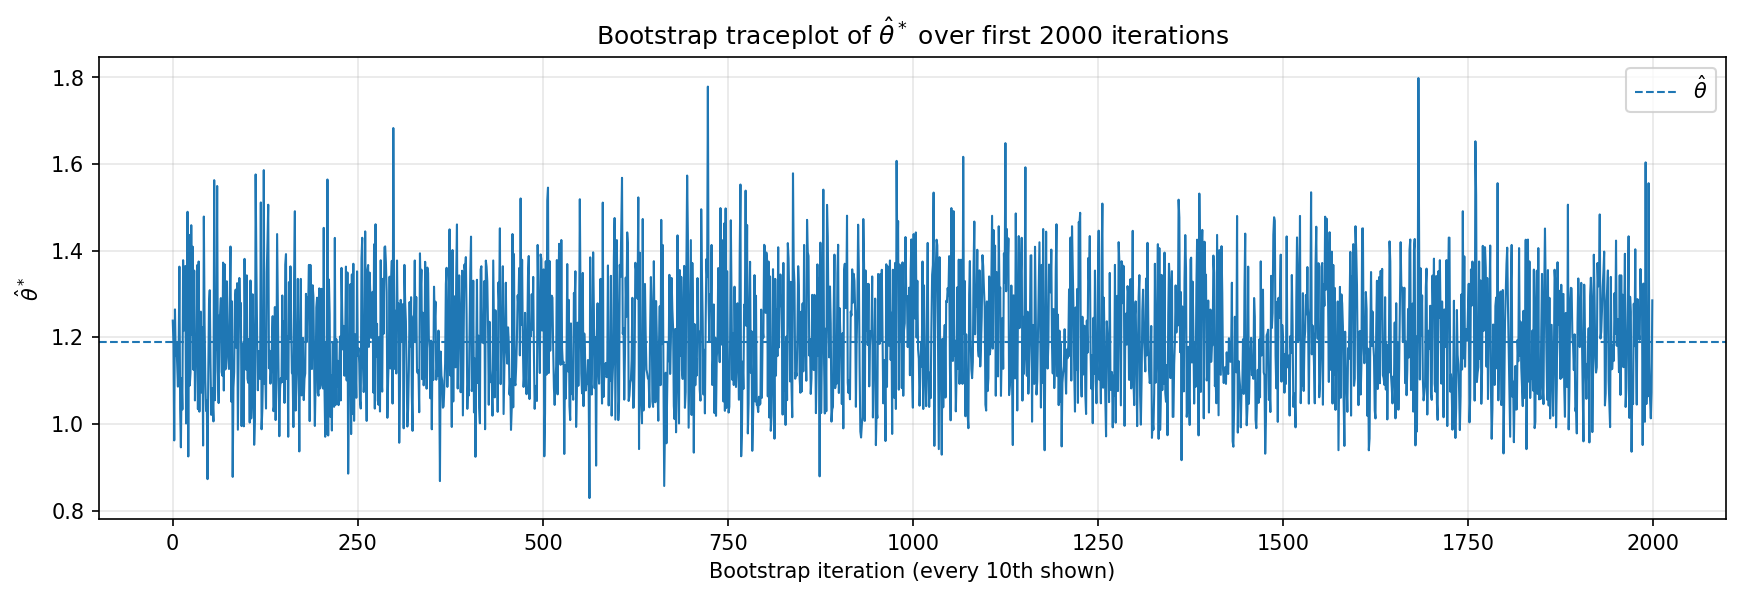

In [4]:
reps = out["reps"]
theta_hat = out["theta_hat"]
ci_lo, ci_hi = out["ci_percentile"]

# thin the series for readability (keeps ~2000 points)
max_points = 2000
step = max(1, len(reps) // max_points)
reps_plot = reps[::step]

plt.figure(figsize=(14, 4), dpi=150)
plt.plot(reps_plot, linewidth=1)
plt.axhline(theta_hat, linestyle="--", linewidth=1, label=r"$\hat{\theta}$")
plt.grid(True, alpha=0.3)
plt.title("Bootstrap traceplot of $\\hat{\\theta}^*$ over first 2000 iterations")
plt.xlabel(f"Bootstrap iteration (every {step}th shown)")
plt.ylabel(r"$\hat{\theta}^*$")
plt.legend()
plt.show()




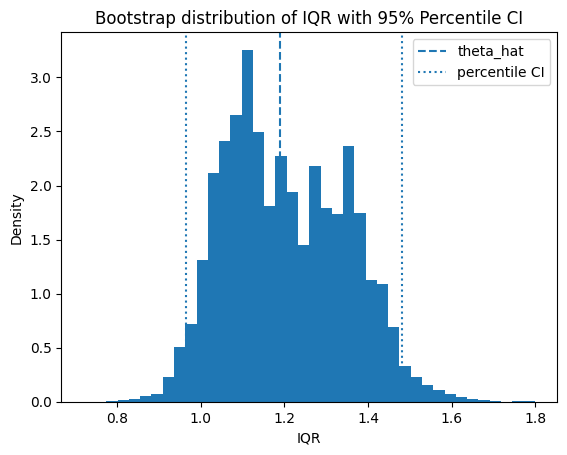

In [5]:
plt.figure()
plt.hist(reps, bins=40, density=True)
plt.axvline(theta_hat, linestyle="--", label="theta_hat")
plt.axvline(ci_lo, linestyle=":", label="percentile CI")
plt.axvline(ci_hi, linestyle=":")
plt.legend()
plt.xlabel("IQR")
plt.ylabel("Density")
plt.title("Bootstrap distribution of IQR with 95% Percentile CI")
plt.show()